# ДЗ 4. Диффузия
В этой домашке вам предстоит обучить DDPM на пресловутых лицах (CelebA 32х32). Решением является решенный ноутбук с обучением модели, сгенерированными картинками и, по требованию проверяющего, чекпоинтами

# Imports and Definitions

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# # Для работы в колабе раскоменьте эти строки
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

Cloning into 'DeepGenerativeModels'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 651 (delta 83), reused 157 (delta 55), pack-reused 447
Receiving objects: 100% (651/651), 176.52 MiB | 23.73 MiB/s, done.
Resolving deltas: 100% (263/263), done.
/content/DeepGenerativeModels


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import einops

import random
import imageio
import numpy as np
from argparse import ArgumentParser


from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torchvision.datasets.mnist import MNIST, FashionMNIST
# from torchvision.datasets import CelebA # Можете использовать стандартный даталодер, если квота гдрайва позволяет
from utils.datasets.celeba import CelebADataset as CelebA


SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Визуализация данных

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().permute(0,2,3,1).numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow((255*(images[idx]+1)/2).astype('uint8'))
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [ ]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Первый батч")
        break

## Загрузка данных (0 баллов)

Мы будем использовать CelebA (32x32). **Важно**: отнормируйте данные в интервал `[-1,1]`.

In [ ]:
# !cd /content/gdrive/MyDrive/celeba && unzip img_align_celeba.zip > /dev/null # распаковка

In [ ]:
batch_size = 128
image_size = 32

transform = ??? # YOUR CODE HERE
# dataset = CelebA("./datasets", download=True, split='train', transform=transform)
dataset = CelebA("/content/gdrive/MyDrive/celeba/", transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

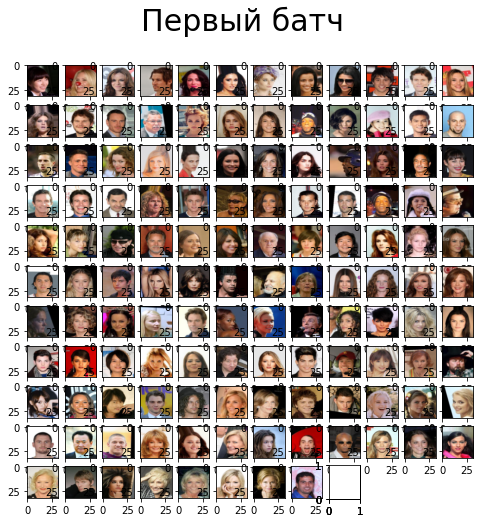

In [ ]:
show_first_batch(loader)

In [ ]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


# Denoising Diffusion Model (DDPM) (2 балла)

## Recap
Диффузия - это обратимый стохастический процесс, в котором картинка зашумляется по известному гауссовскому закону $q(x_t|x_{t-1})$ и денойзится по неизвестному обратному гауссовскому закону $p(x_{t-1}|x_t)$, который приближается нейросетью $p_\theta$
![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

Известный закон $q$ (он же forward pass) описывается по формуле:
$$
\begin{aligned}
\mathbf{x}_t 
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ ;where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}
$$, где $\alpha$ - заранее определенные по определенной сетке константы

Неизвестная же гауссиана обратного закона (он же backward pass) предсказывается нейросетью:
$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_\theta(x_t, t),\sigma_\theta(x_t,t))$ (т.е. предсказываются $\mu$ и $\sigma$, 1в1 как в вариационном енкодере)

Кроме этого, так же, как в варэнкодере, $p_\theta$ выучивается максимизацией ELBO (и даже KL там тоже между двумя гауссианами)

Ну а выучив обратный процесс денойзинга $p_\theta(x_{t-1}|x_t)$, дело останется за малым: берём $x_T\sim\mathcal{N}(0,1)$ и семплируем $x_{t-1}\sim p_\theta(x_{t-1}|x_t)$, пока не восстановим наш незашумленный $x_0$. Это и будет какая-то картинка

## DDPM

С варвыводом вы уже хорошо знакомы, но авторы DDPM решили с ним не париться и забить на $\sigma_t$, сделав её заранее определённой константой, например:
- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

Тогда
$$q(x_{t-1}|x_0, x_t)=\mathcal{N}(x_{t-1}|\mu_t^q,\sigma_t)$$
$$p_\theta(x_{t-1}|x_t)=\mathcal{N}(x_{t-1}|\mu_t^\theta,\sigma_t)$$

Кроме этого, из вышеуказанного прямого закона $q$ несложно представить $\mu_t^q$ в виде 

$$\boldsymbol{\mu}^q_t = \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)$$

Так давайте представим и $\mu^\theta_t$ в таком виде, раз так:
$$\boldsymbol{\mu}^\theta_t = \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t^\theta(x_t,t) \Big)$$ 

Тогда весь $KL(q|p_\theta)$ сведётся к минимизации MSE

$$||\mu_t^q-\mu_t^\theta||^2\sim||\epsilon_t-\epsilon_t^\theta(x_t,t)||^2$$

Ну а зашумленный $x_t$ можно считать из исходного $x_0$ по быстрой формуле (см. самое начало):

$$x_t=\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t$$

$\epsilon_t$ же на деле берут случайно из $\mathcal{N}(0,1)$

Итого, все-эти-ваши диффузии можно представить в виде нескольких строк кода:
![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

Прим. В качестве $\epsilon^\theta$ берут любой Unet-like бэкбон (кроме этого, есть оптимизированный под диффузию Efficient Unet)

Для большей инфы по диффузии идите сюда https://lilianweng.github.io/posts/2021-07-11-diffusion-models/


In [ ]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, # Unet
                 n_steps=???, # YOUR CODE HERE (число шагов диффузии)
                 min_beta=???, # YOUR CODE HERE
                 max_beta=???, # YOUR CODE HERE
                 device=None,
                 image_chw=(3, image_size, image_size)):
        super().__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device) # Ваш backbone (Unet), реализуете его ниже
        self.betas = ??? # Задайте beta по любой понравившейся сетке, как на семинаре
        self.alphas = ???
        self.alpha_bars = ???

    def forward(self, x0, t, eta=None):
        # Прямой проход диффузии (детерменированный марковский процесс)
        # :param x0 - исходная картинка (тензор формы [B,C,H,W])
        # :param t - шаг зашумления (тензор формы [B,1])
        # :param eta - \epsilon_t - добавочный шум на шаге зашумления t (тензор формы [B,C,H,W])
        
        # YOUR CODE HERE
        if eta is None:
            eta = ??? # если шум не определен - инициализируйте его гауссом N(0,1) сами
        noised_x = ??? 
        return noised_x

    def backward(self, x, t):
        # Обратный процесс. Здесь вам предстоит восстановить добавочный шум eta из зашумлённой картинки x на шаге t нейросетью
        eta_pred = self.network(x, t)
        return eta_pred

## Visualizing forward and backward (2 балла)

In [ ]:
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]: # Шаг зашумления (в процентах от максимального)
            noised_images = ??? # YOUR CODE HERE. Зашумите ваши картинки прямым проходом DDPM
            show_images(
                noised_images,
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [ ]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100,
                        gif_name="sampling.gif", c=3, h=image_size, w=image_size):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = ??? # Начинаем генерить картинки с гауссовского шума N(0,1) ([n_samples, c, h, w])

        for idx, t in ???: # Денойзим наши картинки для каждого шага, начиная с последнего
            # Estimating noise to be removed
            time_tensor = ??? # [n_samples, 1].long()
            eta_theta = ??? #  Предсказываем добавочный шум нейросетью

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = ??? # Вычитаем добавочный шум из картинки

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                sigma_t = ??? # определите сигму по любому из предлагаемых DDPM способов

                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                normalized = x.clone()
                ??? # YOUR CODE HERE (нормируем картинку обратно в интервал [0,255])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

# UNet backbone ($\epsilon^\theta$) (3 балла)

Как уже было сказано, в качестве $\epsilon^\theta$ подойдёт любой Unet-like бэкбон (который будет принимать на вход зашумлённую картинку и на выходе возвращать восстановленный шум $\epsilon_t$ той же размерности). Одна незадача - вторым аргументом $\epsilon^\theta$ принимает время (шаг зашумления) $t$, чего в ванильном Unet'e нет.

К счастью, есть миллион и один способ добавить время дополнительным аргументом (например, AdaIN, как в StyleGAN, дополнительным каналом и т.д.)

На практике же в DDPM делают positional encoding (тот самый, который в Трансформере) времени $t$ и дальше просто плюсуют его прямо к входной картинке $x$. Мало того, вместе в временем иногда ещё и какие-нибудь текстовые эмбединги приплюсовывают (сжимая их нехитрым образом до нужной размерности через дополнительный линейный слой)

С текстовыми эмбедингами мы работать в этой домашке не будем, а вот $t$ добавлять будем ровно последним способом 

In [ ]:
def sinusoidal_embedding(n, d):
    # n - размерность исходных данных (в нашем случае число моментов времени)
    # d - выходная размерность
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]) # коэффициенты для d гармоник
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding = ??? # заполните половину из d компонент синунами sin(wk*t), оставшуюся косинусами cos(wk*t), где wk - коэффициенты гармоник
    return embedding

class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super().__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False) # мы эмбединг слой уже инициализировали и менять его не будем

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        ??? # YOUR UNET BLOCKS HERE
    
    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )
    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        x = x + self.te1(t).reshape(n, -1, 1, 1)
        
        out = ??? # (N, 3, 32, 32)

        return out



In [ ]:
# Defining model
n_steps, min_beta, max_beta = ???, ???, ???
ddpm = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
sum([p.numel() for p in ddpm.parameters()])

650430

# Optional visualizations

In [ ]:
# Optionally, load a pre-trained model that will be further trained
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

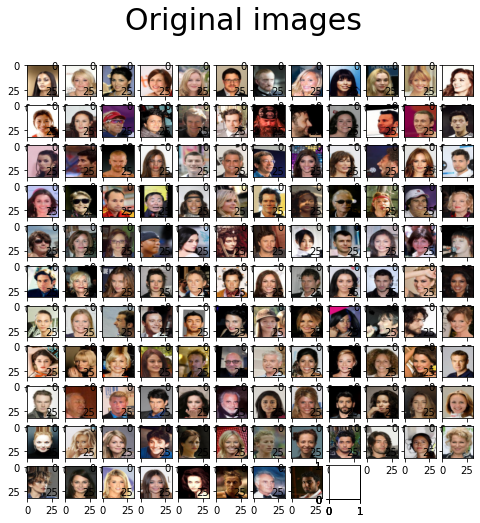

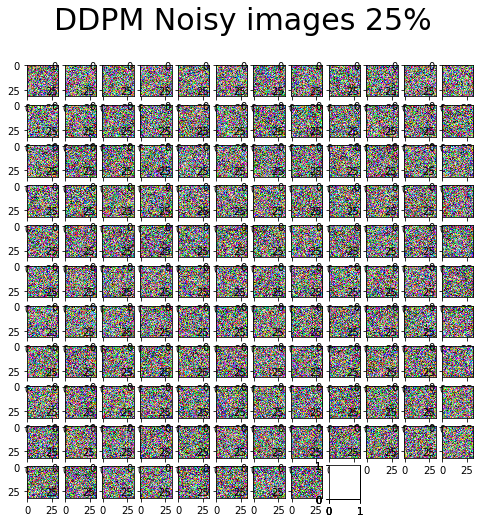

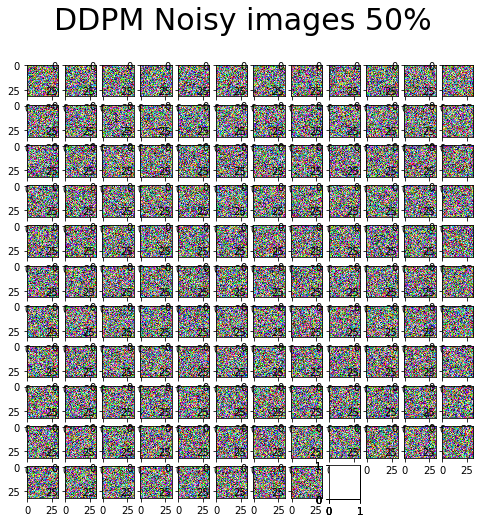

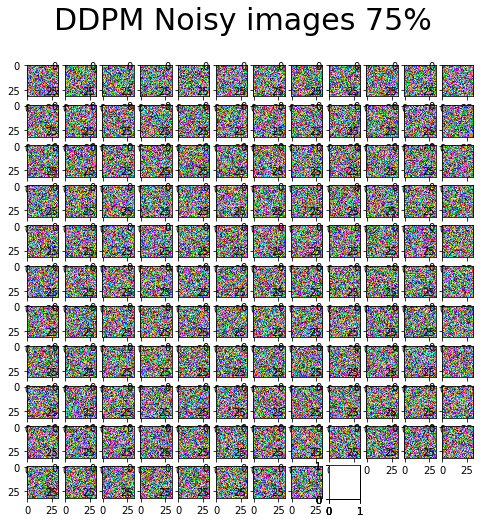

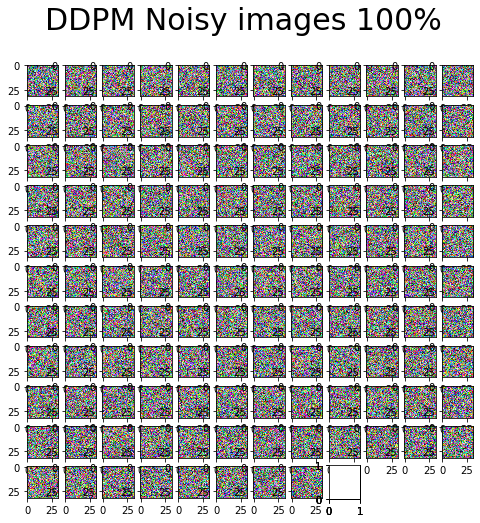

In [ ]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

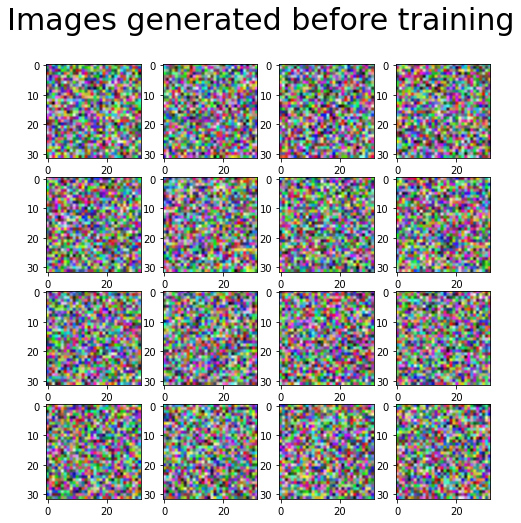

In [ ]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

# Обучение (1 балл)
![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

In [ ]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            x0 = batch[0].to(device)
            
            eta = ??? # инициализируем добавочный шум
            t = ???

            noisy_imgs = ??? # получаем зашумленное изображение для шага t 

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ??? # восстанавливаем добавочный шум

            loss = ??? # учимся его восстанавливать нейросетью
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [ ]:
store_path = "/content/gdrive/MyDrive/checkpoints/celeba_ddpm.ckpt"

In [ ]:
# Training
n_epochs = ???
lr = ???
if not os.path.isdir(os.path.dirname(store_path)): os.mkdir(os.path.dirname(store_path))
training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 1: 0.037 --> Best model ever (stored)


Epoch 2/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 2: 0.036 --> Best model ever (stored)


Epoch 3/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 3: 0.035 --> Best model ever (stored)


Epoch 4/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 4: 0.035


Epoch 5/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 5: 0.035


Epoch 6/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 6: 0.035 --> Best model ever (stored)


Epoch 7/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 7: 0.035 --> Best model ever (stored)


Epoch 8/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 8: 0.035 --> Best model ever (stored)


Epoch 9/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 9: 0.034 --> Best model ever (stored)


Epoch 10/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 10: 0.034 --> Best model ever (stored)


Epoch 11/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 11: 0.034


Epoch 12/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 12: 0.034


Epoch 13/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 13: 0.033 --> Best model ever (stored)


Epoch 14/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 14: 0.033 --> Best model ever (stored)


Epoch 15/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 15: 0.033 --> Best model ever (stored)


Epoch 16/200:   0%|          | 0/1272 [00:00<?, ?it/s]

Loss at epoch 16: 0.033 --> Best model ever (stored)


Epoch 17/200:   0%|          | 0/1272 [00:00<?, ?it/s]

# Генерёжка (2 балла за хорошие картинки)

In [ ]:
# Loading the trained model
best_model = DDPM(UNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [ ]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="celeba.gif"
    )
show_images(generated, "Final result")

# Visualizing the diffusion

In [ ]:
from IPython.display import Image

Image(open('celeba.gif','rb').read())